In [81]:
print('ACIT 4620')
print('\nGroup-6')
print('\nparticipate: Julie Hallen, Brage Ramberg, Alexander bazo, Daniel Bjordal, , Harith Elamin')

ACIT 4620

Group-6

participate: Julie Hallen, Brage Ramberg, Alexander bazo, Daniel Bjordal, , Harith Elamin


In [6]:
print('Tools and Libraries:')
print('\n1- Python 3.')
print('\n2- scikit-fuzzy for fuzzy logic and fuzzy systems')
print('\n3- networkx for the creation, manipulation')
print('\n4- NumPy for numerical computations.')
print('\n5- pandas for data manipulation and analysis.')
print('\n6- requests for the process of sending and receiving data from websites.')
print('\n7- Matplotlib for plotting results.')
print('\n8-Keras for the convenience of mathematical calculations')


Tools and Libraries:

1- Python 3.

2- scikit-fuzzy for fuzzy logic and fuzzy systems

3- networkx for the creation, manipulation

4- NumPy for numerical computations.

5- pandas for data manipulation and analysis.

6- requests for the process of sending and receiving data from websites.

7- Matplotlib for plotting results.

8-Keras for the convenience of mathematical calculations


In [10]:
!pip3 freeze
!pip3 install pandas scikit-fuzzy -U scikit-learn networkx numpy tensorflow keras matplotlib requests pandas

about-time==4.2.1
alive-progress==3.1.5
asttokens==2.4.1
autograd==1.7.0
beautifulsoup4==4.12.3
certifi==2024.8.30
charset-normalizer==3.4.0
cloudpickle==3.1.0
cma==3.2.2
colorama==0.4.6
comm==0.2.2
contourpy==1.3.0
cycler==0.12.1
deap==1.4.1
debugpy==1.8.7
decorator==5.1.1
Deprecated==1.2.14
dill==0.3.9
executing==2.1.0
Farama-Notifications==0.0.4
fonttools==4.54.1
frozendict==2.4.6
grapheme==0.6.0
gym==0.26.2
gym-notices==0.0.8
gymnasium==1.0.0
html5lib==1.1
idna==3.10
ipykernel==6.29.5
ipython==8.28.0
jedi==0.19.1
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.7
lxml==5.3.0
matplotlib==3.9.2
matplotlib-inline==0.1.7
multitasking==0.0.11
nest-asyncio==1.6.0
networkx==3.4.2
numpy==2.1.3
packaging==24.1
pandas==2.2.3
parso==0.8.4
peewee==3.17.7
pillow==11.0.0
platformdirs==4.3.6
prompt_toolkit==3.0.48
psutil==6.1.0
pure_eval==0.2.3
Pygments==2.18.0
pymoo==0.6.1.3
pyparsing==3.2.0
python-dateutil==2.9.0.post0
pytz==2024.2
pywin32==308
pyzmq==26.2.0
requests==2.3

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.26.0 Requires-Python <3.13,>=3.9; 1.26.1 Requires-Python <3.13,>=3.9
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [83]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split


In [127]:
import sys
print('System version',sys.version)

System version 3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]


Project Proposal:

Datasets:

Employment history feature: 
https://www.kaggle.com/competitions/playground-series-s4e10/data?select=train.csv&fbclid=IwZXh0bgNhZW0CMTEAAR3m8MTqUNOmYlHeO4aSG3t27BQAZmFUhklp47HlrgQKs-a_jqKvER8MLxI_aem_wnn0vq8GNdEFy5I6HQg8XA

Credit score dataset feature: 
https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset?fbclid=IwZXh0bgNhZW0CMTEAAR3qB690tKMRmu3WPfOR3JX_uWnwWm5UZ8egilKtbPSOXpd80po5694E-Ew_aem_y6J4ieYEDtECW1CeA750dQ

In [128]:
# Read the CSV file
train_data = pd.read_csv('../ACIT4620-24H-G6/dataset/train.csv')
test_data = pd.read_csv('../ACIT4620-24H-G6/dataset/test.csv')
val_data = pd.read_csv('../ACIT4620-24H-G6/dataset/sample_submission.csv')

In [129]:
# Print the columns
print(train_data.columns)

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')


In [87]:
# Print dataset colums
train_data.head(100)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,36,96000,MORTGAGE,5.0,PERSONAL,A,15000,5.99,0.16,N,12,0
96,96,28,70000,RENT,9.0,HOMEIMPROVEMENT,B,12000,11.48,0.17,N,10,0
97,97,25,36000,MORTGAGE,1.0,MEDICAL,A,8000,6.91,0.22,N,2,0
98,98,29,34000,RENT,9.0,HOMEIMPROVEMENT,D,3000,16.32,0.08,Y,8,1


In [130]:
# Define fuzzy variables (input variables)
# We selected the most important columns from the dataset to use later in the rules.
selected_columns = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'loan_status']

person_age = ctrl.Antecedent(np.arange(18, 101, 1), 'person_age')
person_income = ctrl.Antecedent(np.arange(0, 500000, 1000), 'person_income')
loan_amnt = ctrl.Antecedent(np.arange(1000, 50000, 500), 'loan_amnt')
loan_int_rate = ctrl.Antecedent(np.arange(0, 30, 0.1), 'loan_int_rate')
loan_percent_income = ctrl.Antecedent(np.arange(0, 1, 0.01), 'loan_percent_income')
loan_status = ctrl.Consequent(np.arange(0, 2, 1), 'loan_status')

In [131]:
selected_data = train_data[selected_columns]

In [136]:
selected_data = train_data[selected_columns]
print(selected_data.head(5))


   person_age  person_income  loan_amnt  loan_int_rate  loan_percent_income  \
0          37          35000       6000          11.49                 0.17   
1          22          56000       4000          13.35                 0.07   
2          29          28800       6000           8.90                 0.21   
3          30          70000      12000          11.11                 0.17   
4          22          60000       6000           6.92                 0.10   

   loan_status  
0            0  
1            0  
2            0  
3            0  
4            0  


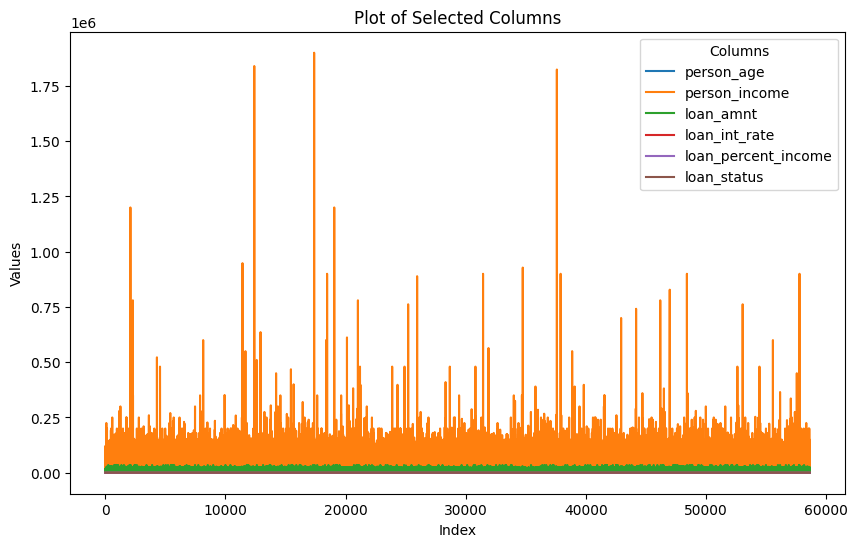

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

columns_to_plot = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'loan_status']

# Plot the data 
train_data[columns_to_plot].plot(kind='line', figsize=(10, 6))

# Adding titles and labels using matplotlib (plt)
plt.title('Plot of Selected Columns')  
plt.xlabel('Index') 
plt.ylabel('Values') 

# Adding a legend with a title
plt.legend(title='Columns')

# Show the plot
plt.show()  


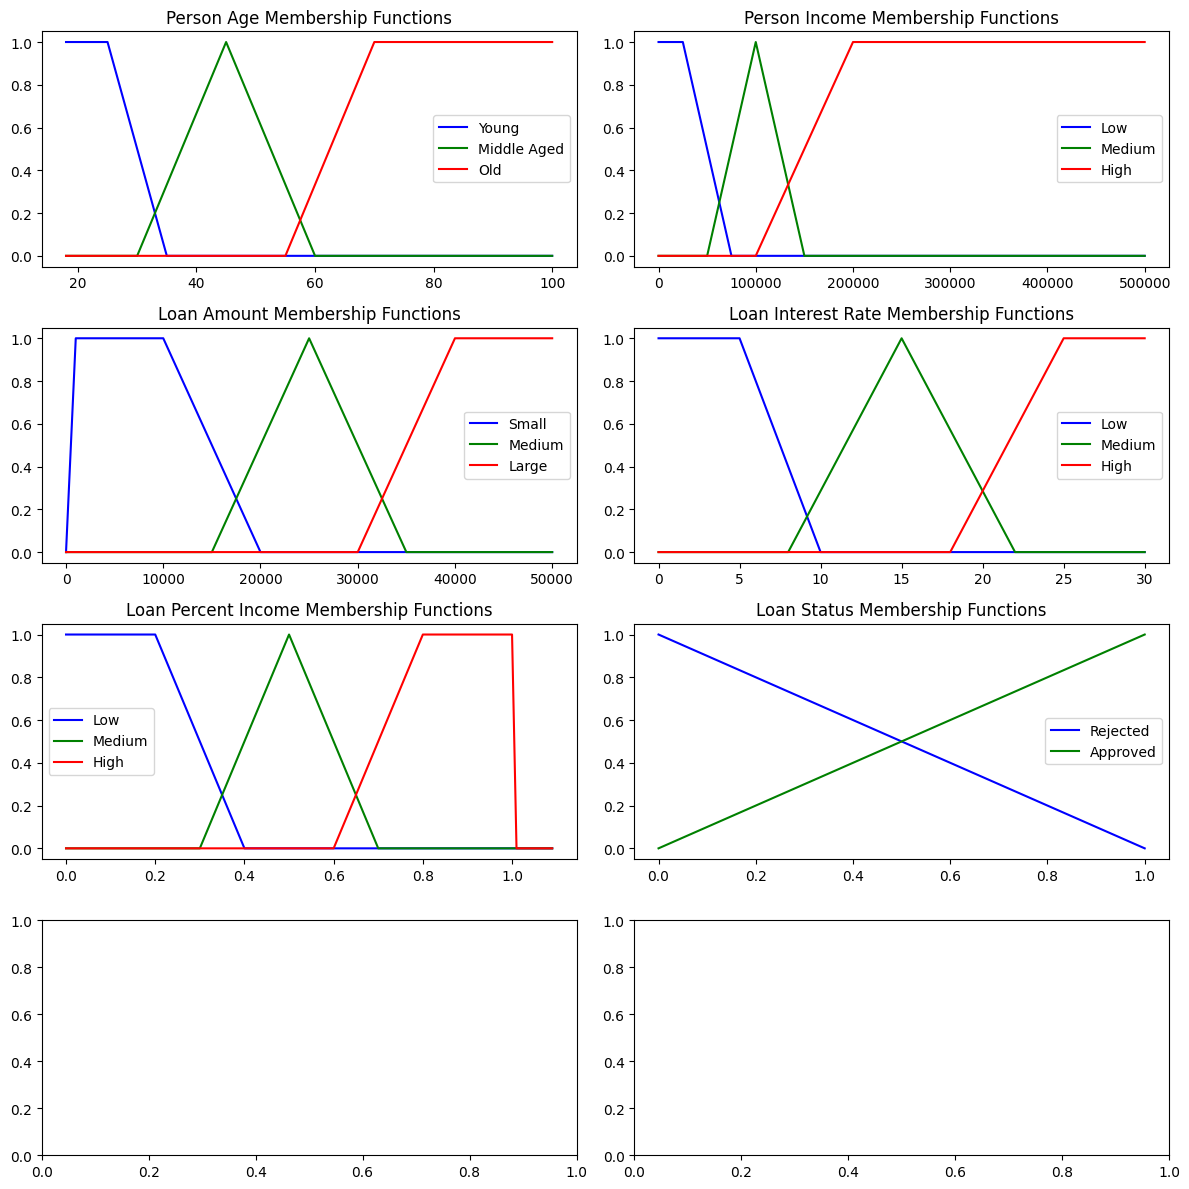

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Define each variable
person_age = np.arange(18, 101, 1)
person_income = np.arange(0, 500001, 1000)
loan_amnt = np.arange(0, 50001, 1000)
loan_int_rate = np.arange(0, 31, 1)
loan_percent_income = np.arange(0, 1.1, 0.01)
loan_status = np.arange(0, 2, 1)

# Define person_age
young = fuzz.trapmf(person_age, [18, 18, 25, 35])
middle_aged = fuzz.trimf(person_age, [30, 45, 60])
old = fuzz.trapmf(person_age, [55, 70, 101, 101])

# Define person_income
low_income = fuzz.trapmf(person_income, [0, 0, 25000, 75000])
medium_income = fuzz.trimf(person_income, [50000, 100000, 150000])
high_income = fuzz.trapmf(person_income, [100000, 200000, 500000, 500000])

# Define loan_amnt
small_loan = fuzz.trapmf(loan_amnt, [1000, 1000, 10000, 20000])
medium_loan = fuzz.trimf(loan_amnt, [15000, 25000, 35000])
large_loan = fuzz.trapmf(loan_amnt, [30000, 40000, 50000, 50000])

# Define loan_int_rate
low_int_rate = fuzz.trapmf(loan_int_rate, [0, 0, 5, 10])
medium_int_rate = fuzz.trimf(loan_int_rate, [8, 15, 22])
high_int_rate = fuzz.trapmf(loan_int_rate, [18, 25, 30, 30])

# Define loan_percent_income
low_percent_income = fuzz.trapmf(loan_percent_income, [0, 0, 0.2, 0.4])
medium_percent_income = fuzz.trimf(loan_percent_income, [0.3, 0.5, 0.7])
high_percent_income = fuzz.trapmf(loan_percent_income, [0.6, 0.8, 1, 1])

# Define loan_status
rejected = fuzz.trimf(loan_status, [0, 0, 1])
approved = fuzz.trimf(loan_status, [0, 1, 1])

# Plotting the fuzzy membership functions
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

# Plot person_age fuzzy sets
axs[0, 0].plot(person_age, young, label='Young', color='blue')
axs[0, 0].plot(person_age, middle_aged, label='Middle Aged', color='green')
axs[0, 0].plot(person_age, old, label='Old', color='red')
axs[0, 0].set_title('Person Age Membership Functions')
axs[0, 0].legend()

# Plot person_income fuzzy sets
axs[0, 1].plot(person_income, low_income, label='Low', color='blue')
axs[0, 1].plot(person_income, medium_income, label='Medium', color='green')
axs[0, 1].plot(person_income, high_income, label='High', color='red')
axs[0, 1].set_title('Person Income Membership Functions')
axs[0, 1].legend()

# Plot loan_amnt fuzzy sets
axs[1, 0].plot(loan_amnt, small_loan, label='Small', color='blue')
axs[1, 0].plot(loan_amnt, medium_loan, label='Medium', color='green')
axs[1, 0].plot(loan_amnt, large_loan, label='Large', color='red')
axs[1, 0].set_title('Loan Amount Membership Functions')
axs[1, 0].legend()

# Plot loan_int_rate fuzzy sets
axs[1, 1].plot(loan_int_rate, low_int_rate, label='Low', color='blue')
axs[1, 1].plot(loan_int_rate, medium_int_rate, label='Medium', color='green')
axs[1, 1].plot(loan_int_rate, high_int_rate, label='High', color='red')
axs[1, 1].set_title('Loan Interest Rate Membership Functions')
axs[1, 1].legend()

# Plot loan_percent_income fuzzy sets
axs[2, 0].plot(loan_percent_income, low_percent_income, label='Low', color='blue')
axs[2, 0].plot(loan_percent_income, medium_percent_income, label='Medium', color='green')
axs[2, 0].plot(loan_percent_income, high_percent_income, label='High', color='red')
axs[2, 0].set_title('Loan Percent Income Membership Functions')
axs[2, 0].legend()

# Plot loan_status fuzzy sets
axs[2, 1].plot(loan_status, rejected, label='Rejected', color='blue')
axs[2, 1].plot(loan_status, approved, label='Approved', color='green')
axs[2, 1].set_title('Loan Status Membership Functions')
axs[2, 1].legend()


plt.tight_layout()
plt.show()


In [92]:
# Define fuzzy control system variables
age = ctrl.Antecedent(person_age, 'age')
income = ctrl.Antecedent(person_income, 'income')
loan = ctrl.Antecedent(loan_amnt, 'loan')
int_rate = ctrl.Antecedent(loan_int_rate, 'int_rate')
percent_income = ctrl.Antecedent(loan_percent_income, 'percent_income')
status = ctrl.Consequent(loan_status, 'status')

In [94]:
# Assign fuzzy sets to variables
age['young'] = young
age['middle_aged'] = middle_aged
age['old'] = old

income['low_income'] = low_income
income['medium_income'] = medium_income
income['high_income'] = high_income

loan['small_loan'] = small_loan
loan['medium_loan'] = medium_loan
loan['large_loan'] = large_loan

int_rate['low_int_rate'] = low_int_rate
int_rate['medium_int_rate'] = medium_int_rate
int_rate['high_int_rate'] = high_int_rate

percent_income['low_percent_income'] = low_percent_income
percent_income['medium_percent_income'] = medium_percent_income
percent_income['high_percent_income'] = high_percent_income

status['rejected'] = rejected
status['approved'] = approved


In [95]:
# Define fuzzy rules
rule1 = ctrl.Rule(age['young'] & income['low_income'], status['approved'])
rule2 = ctrl.Rule(age['middle_aged'] & income['medium_income'] & loan['medium_loan'] & int_rate['low_int_rate'], status['approved'])
rule3 = ctrl.Rule(age['old'] & income['low_income'] & loan['large_loan'], status['rejected'])
rule4 = ctrl.Rule(age['young'] & income['high_income'] & loan['small_loan'] & int_rate['low_int_rate'], status['approved'])
rule5 = ctrl.Rule(income['low_income'] & percent_income['high_percent_income'], status['rejected'])
rule6 = ctrl.Rule(int_rate['high_int_rate'], status['rejected'])

In [96]:
# Create the control system
loan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
loan_decision = ctrl.ControlSystemSimulation(loan_ctrl)

In [97]:
#Split the dataset into X, and y.
X = train_data[['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']]
# target_column = 'loan_status'
y = train_data['loan_status']

In [98]:
# Split the training data into X_train, X_val, y_train, y_val
# using 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
# Prepare X test
X_test = test_data[['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']]

In [100]:
# Display the shapes of the datasets
print(f"Full Dataset: {train_data.shape}")
print(f"Training Dataset: {val_data.shape}")
print(f"Testing Dataset: {test_data.shape}")

Full Dataset: (58645, 13)
Training Dataset: (39098, 2)
Testing Dataset: (39098, 12)


In [101]:
# Print the shapes of the splits to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (46916, 5), y_train shape: (46916,)
X_val shape: (11729, 5), y_val shape: (11729,)
X_test shape: (39098, 5)


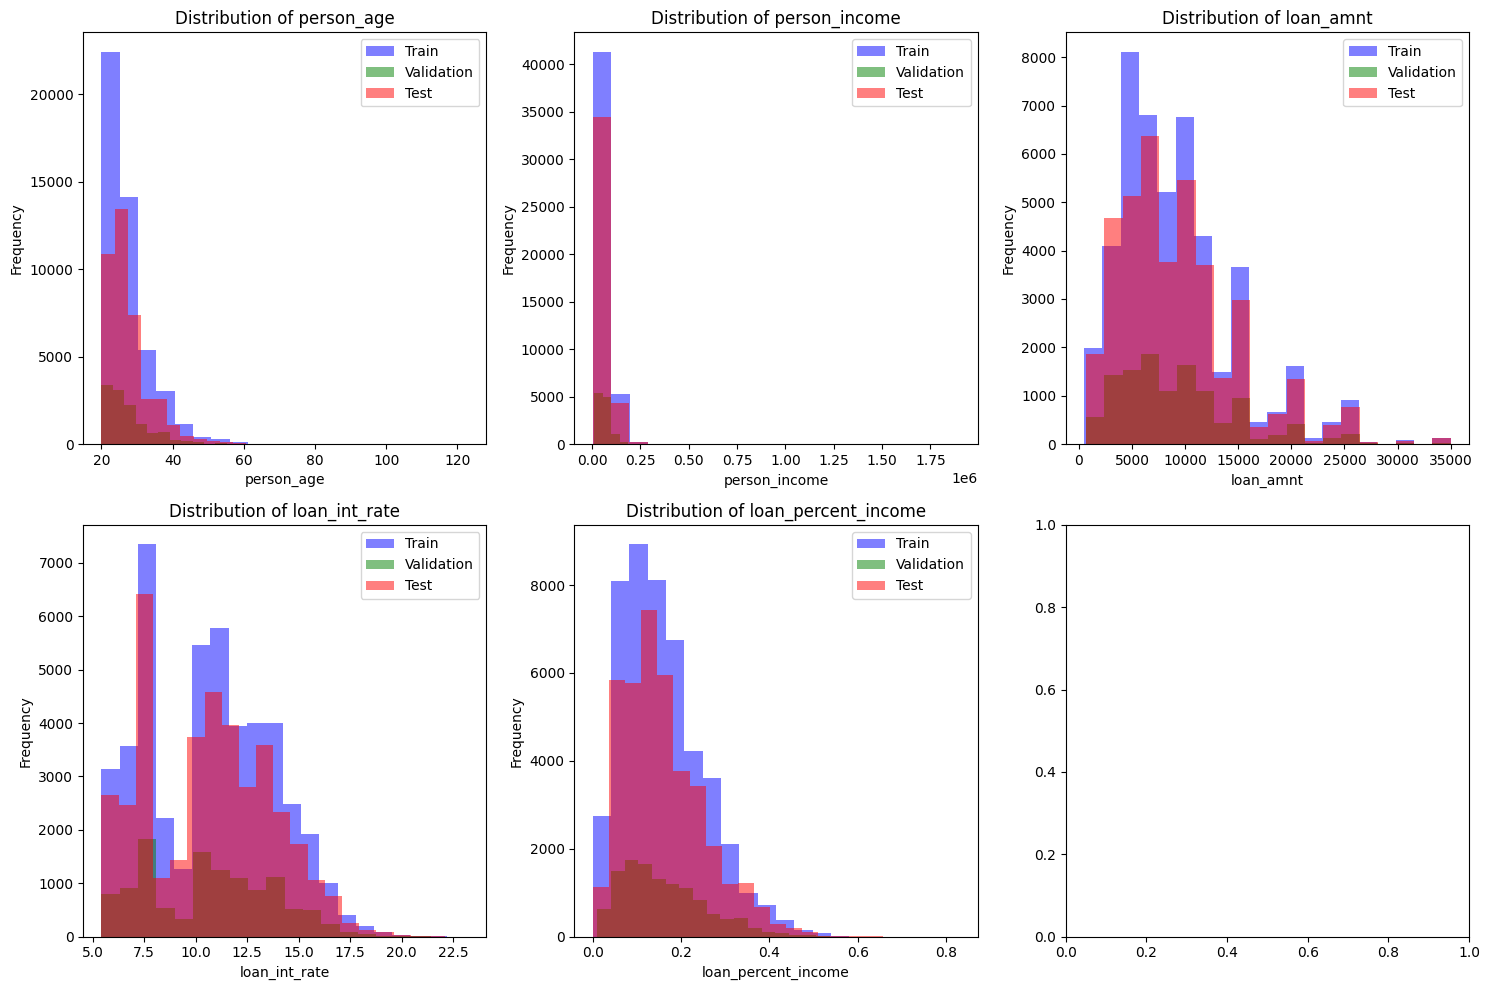

In [102]:
import matplotlib.pyplot as plt

# Plot histograms for X_train, X_val, and X_test
def plot_histograms(X_train, X_val, X_test, n_cols=3):
    n_features = len(X_train.columns)
    n_rows = (n_features // n_cols) + (1 if n_features % n_cols != 0 else 0)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    
    # Loop through all features in X_train and plot histograms for each
    for i, feature in enumerate(X_train.columns):
        axes[i].hist(X_train[feature], bins=20, alpha=0.5, label='Train', color='blue')
        axes[i].hist(X_val[feature], bins=20, alpha=0.5, label='Validation', color='green')
        axes[i].hist(X_test[feature], bins=20, alpha=0.5, label='Test', color='red')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_histograms(X_train, X_val, X_test)


In [103]:
# Fuzzy control system
loan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
loan_decision = ctrl.ControlSystemSimulation(loan_ctrl)

In [105]:
# predict loan approval/rejection using the fuzzy control system
def predict_loan_decision(sample, loan_decision):
    # Sample is a single row from the dataset (like one row of X_train, X_val, etc.)
    person_age_value = sample['person_age']
    person_income_value = sample['person_income']
    loan_amnt_value = sample['loan_amnt']
    loan_int_rate_value = sample['loan_int_rate']
    loan_percent_income_value = sample['loan_percent_income']
    
    # Step 4: Set inputs to the fuzzy system (i.e., input the values to the fuzzy variables)
    loan_decision.input['person_age'] = person_age_value
    loan_decision.input['person_income'] = person_income_value
    loan_decision.input['loan_amnt'] = loan_amnt_value
    loan_decision.input['loan_int_rate'] = loan_int_rate_value
    loan_decision.input['loan_percent_income'] = loan_percent_income_value
    
    # Step 5: Compute the fuzzy inference system
    loan_decision.compute()
    
    # Step 6: Extract the result from the fuzzy system output
    loan_approval_score = loan_decision.output['loan_status']
    
    # Output score (optional): You may decide to round or map this score into "approved" or "rejected"
    if loan_approval_score > 0.5:
        return 'approved'
    else:
        return 'rejected'

In [157]:
# Getting a random sample from test dataset
sample_data = test_data.sample(n=1)

In [158]:
for index, sample in test_data.iterrows():
    predicted_status = predict_loan_decision(sample, loan_decision)
    print(f"Sample {index}: Loan decision: {predicted_status}")

ValueError: Unexpected input: person_age

In [153]:
print(sample_data.head())

          id  person_age  person_income person_home_ownership  \
11883  70528          22          58000                  RENT   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
11883                4.0   EDUCATION          A       6000           7.51   

       loan_percent_income cb_person_default_on_file  \
11883                  0.1                         N   

       cb_person_cred_hist_length  
11883                           3  
